In [ ]:
import mkl
mkl.set_num_threads(1)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

from firesong.Firesong import firesong_simulation
from firesong.FluxPDF import flux_pdf
import pandas as pd
from os.path import join
import seaborn as sns
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
Planck18.luminosity_distance(0.3365) # TXS 0506+056

# flux references

In [ ]:
logE = np.linspace(2, 7)
E = 10**logE  # GeV
E0 = 1e3
gamma = 3.2
flux_ngc = lambda energy: 5e-14 * (energy / E0) ** -gamma  # / GeV cm^2 s
flux_diffuse = lambda energy: 1.8e-18 * (energy / 1e5) ** -2.52
flux_diffuse_soft = lambda energy: 3e-8 / (1e4**2) * (energy / 1e4) ** -3.2
_prefactor = 1  # 1E-3

plt.figure(figsize=(10, 8))

plt.loglog(E, _prefactor * (E**2) * flux_ngc(E), label="ngc")
plt.loglog(
    E,
    _prefactor * (E**2) * flux_diffuse(E) * 4 * np.pi,
    label="integrated diffuse, SPL",
)
plt.loglog(
    E,
    _prefactor * (E**2) * flux_diffuse_soft(E) * 4 * np.pi,
    label="integrated diffuse, soft gamma normalized",
)

plt.grid()
plt.ylabel(r"$E^2$ flux  $ \rm GeV / cm^2 s $")
plt.xlabel(r"E / GeV")
plt.xlim(1e3, 1e7)
# plt.ylim(1e-14, 1.5e-9)
plt.legend(loc=2, bbox_to_anchor=(0, 1., 0, 0), frameon=False)

E_ref = 1e5

norm_ngc = (E_ref**2) * flux_ngc(E_ref)
norm_diffuse = (E_ref**2) * flux_diffuse(E_ref)
norm_diffuse_soft = (E_ref**2) * flux_diffuse_soft(E_ref)

plt.axhline(norm_ngc, color="gray", ls="--")
print(norm_ngc)
plt.axhline(norm_diffuse * 4 * np.pi, color="gray", ls="--")
print(norm_diffuse)
plt.axhline(norm_diffuse_soft * 4 * np.pi, color="gray", ls="--")
print(norm_diffuse_soft)

fluxnorm E^2 dPhi/dE = GeV s^-1 cm^-2 sr^-1 (default 1.44E-8)

total_flux: per steradian; flux per source: GeV s^-1 cm^-2

# load flux DP for NGC-like sources

In [3]:
BASEPATH = "/home/hpc/capn/capn102h/repos/Plenum"

In [4]:
ngc_flux_ps = pd.read_pickle(join("/home/hpc/capn/capn102h/repos/Plenum", "resources/flux_ngc_disc_pot.pickle"))
flux_agg = ngc_flux_ps.groupby("ident").aggregate({"disc5": ["min", "max", "mean"]})
flux_agg.columns = flux_agg.columns.droplevel()
flux_h = pd.DataFrame(ngc_flux_ps.groupby("ident").apply(
    lambda x: x.loc[np.isclose(x.dec, 0)]["disc5"]
))
flux_h.index = flux_h.index.droplevel(1)
flux_h.columns = ["horizon"]

flux_agg = pd.concat([flux_agg, flux_h], axis=1)

calc_E2norm = lambda E_ref, norm, gamma: (E_ref**2) * norm * (E_ref / E0) ** -gamma

# simulate various PDFs

In [5]:
from itertools import product

In [97]:
simPDF_ngc = {}
_kw = dict(
    outputdir=None,
    filename=None,
    index=3.2,
    Evolution="MD2014SFR",
    logFMin=-35,
    logFMax=0,
    emin=100,
    LumMin=1e30,
    LumMax=1e60,
    verbose=False,
    with_dFdz=True,
    nFluxBins=50,
)
_list = []
# densities = np.round(np.arange(5.0, 11.1, step=1), decimals=1)
# for indx, _width, _fluxref in product(densities, [1], [1, 0.1]):
#     # print(indx)
for _fluxref in [1, 0.1]:
    if _fluxref==1:
        densities = np.arange(5, 8, step=1)
    else:
        densities = np.arange(9, 12, step=1)
    for indx in densities:
        _tmp = flux_pdf(
            density=np.power(10, -indx*1.0),
            LF="SC", #"LG",
            # sigma=_width,
            fluxnorm=norm_diffuse_soft * _fluxref,
            **_kw
        )
        _list.append(
            pd.DataFrame(
                {
                    "Local source density": fr"$10^{{{-indx}}}$/Mpc$^3$",
                    "width": "SC",
                    "Fraction of total flux": _fluxref,
                    "flux": _tmp[0][::-1],
                    "Nsrc": _tmp[1][::-1],
                }
            )
        )
df = pd.concat(_list)
df["cumulative_Nsrc"] = df.groupby(["Local source density", "width", "Fraction of total flux"]).cumsum().Nsrc

# plots

In [123]:
cmap = sns.color_palette(
    np.concatenate(
        [sns.color_palette("crest", n_colors=3), sns.color_palette("magma", n_colors=3)]
    )
)

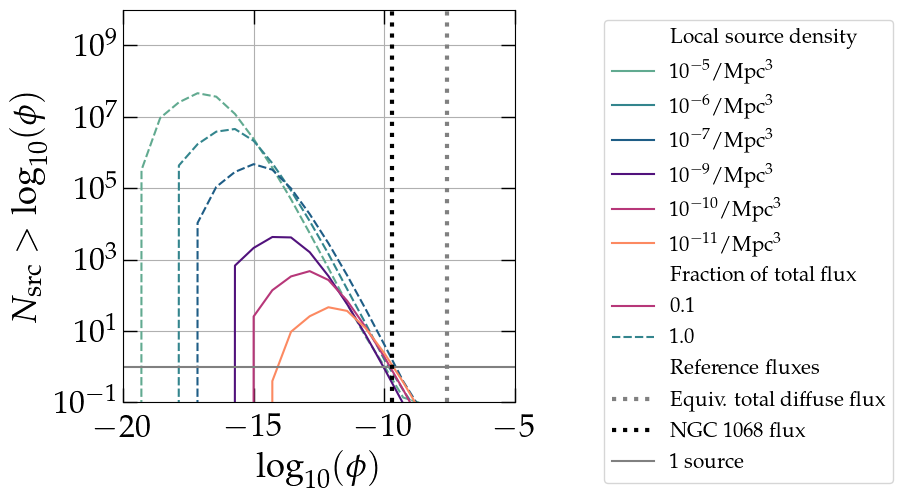

In [124]:
ax = sns.lineplot(
    data=df,
    x="flux",
    y="Nsrc",
    hue="Local source density",
    # size="width",
    style="Fraction of total flux",
    palette=cmap,
)
# just for legend
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="Gray",
    ls=":",
    label="Equiv. total diffuse flux",
    lw=3,
)
plt.axvline(
    np.log10(norm_ngc), ls=":", color="k", label="NGC 1068 flux", zorder=100, lw=3
)


# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="Gray", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
lg = plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.99, 1))
lg.legend_handles[8].set_color(cmap[4])
lg.legend_handles[9].set_color(cmap[1])
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

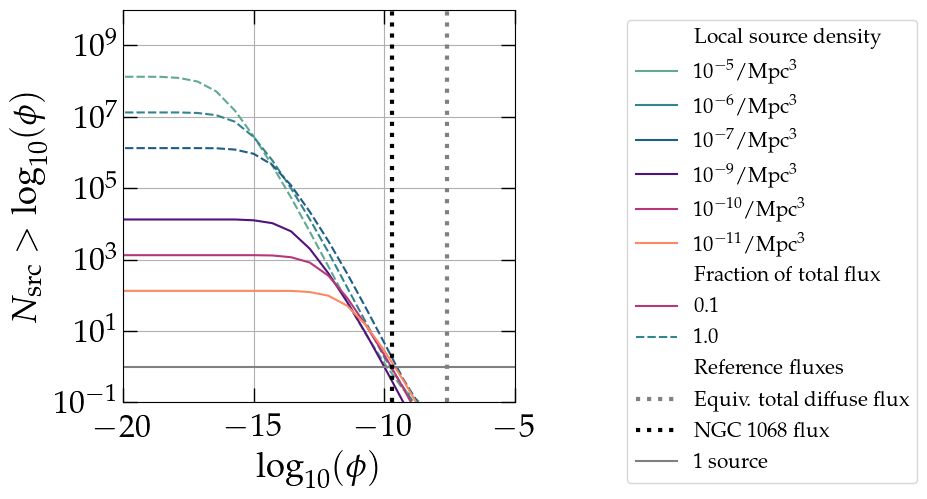

In [138]:
ax = sns.lineplot(
    data=df,
    x="flux",
    y="cumulative_Nsrc",
    hue="Local source density",
    # size="width",
    style="Fraction of total flux",
    palette=cmap,
)
# just for legend
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="Gray",
    ls=":",
    label="Equiv. total diffuse flux",
    lw=3,
)
plt.axvline(
    np.log10(norm_ngc), ls=":", color="k", label="NGC 1068 flux", zorder=100, lw=3
)


# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="Gray", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
lg = plt.legend(loc=1, bbox_to_anchor=(1, 0, 1.05, 1))
lg.legend_handles[8].set_color(cmap[4])
lg.legend_handles[9].set_color(cmap[1])
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

Text(0, 0.5, '$N_{\\rm src} > \\log_{10}(\\phi)$')

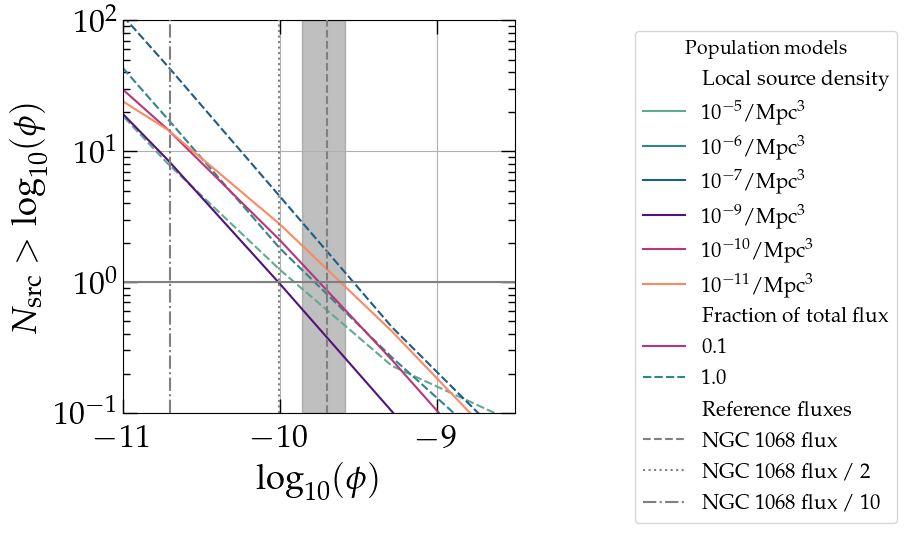

In [139]:
ax = sns.lineplot(
    data=df,
    x="flux",
    y="cumulative_Nsrc",
    hue="Local source density",
    # size="width",
    style="Fraction of total flux",
    palette=cmap,
)

plt.axvspan(
    np.log10(norm_ngc / (5 / 3.5)),
    np.log10(norm_ngc / (5 / 6.5)),
    alpha=0.5,
    color="gray",
)
plt.plot(np.nan, np.nan, label="Reference fluxes", color="w")
# plt.axvline(
#     np.log10(norm_diffuse_soft * 4 * np.pi),
#     color="Gray",
#     ls=":",
#     label="Equiv. total diffuse flux",
# )
plt.axvline(
    np.log10(norm_ngc),
    ls="--",
    color="gray",
    label="NGC 1068 flux",
    zorder=100,
)
plt.axvline(
    np.log10(norm_ngc / 2),
    ls=":",
    color="gray",
    label="NGC 1068 flux / 2",
    zorder=100,
)
plt.axvline(
    np.log10(norm_ngc / 10),
    ls="-.",
    color="gray",
    label="NGC 1068 flux / 10",
    zorder=100,
)
# for _l in flux_agg.values.flatten():
#     _flux = calc_E2norm(1e5, _l, 3.2)
#     plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")

lg = plt.legend(loc=1, bbox_to_anchor=(1, 0, 1, 1), title="Population models")

lg.legend_handles[8].set_color(cmap[4])
lg.legend_handles[9].set_color(cmap[1])
plt.xlim(-11, -8.5)
plt.ylim(1e-1, 100)
plt.axhline(1, color="Gray")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")

In [66]:
from scipy.stats import poisson

In [86]:
poisson.pmf(1, 0.4)

0.2681280184142557

0.4 0.0007150080491046819
1 0.015328310048810103
2 0.09022352215774178
3 0.16803135574154085
4 0.1953668148131645


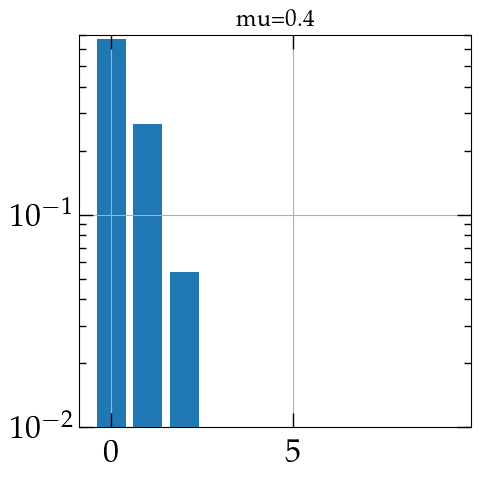

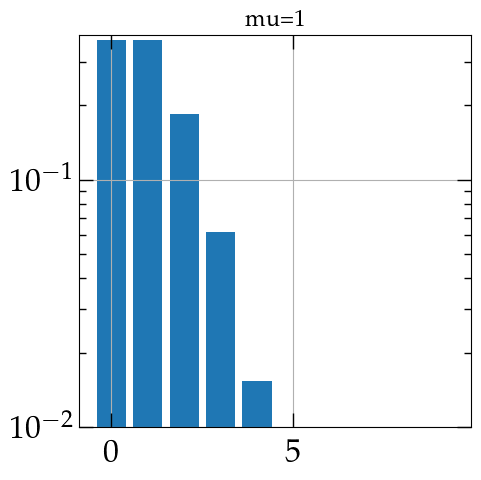

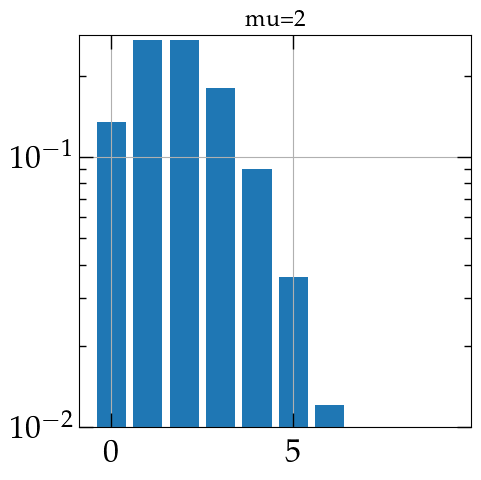

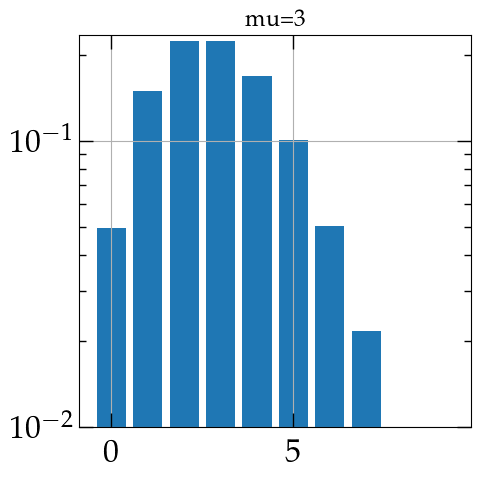

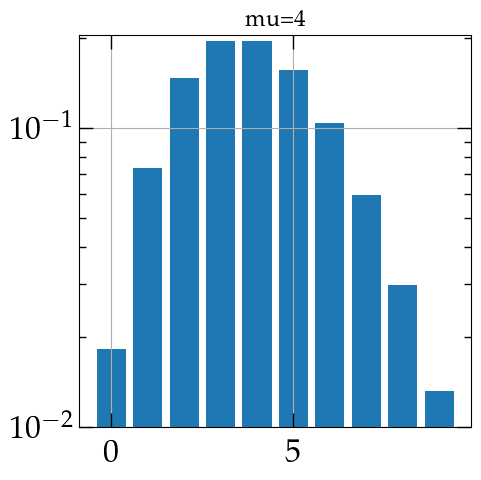

In [87]:
nums = np.arange(10)
for i in [0.4, 1, 2, 3, 4]:
    plt.figure()
    plt.title(f"mu={i}")
    plt.bar(nums, poisson.pmf(nums, i))
    print(i, poisson.pmf(4, i))
    plt.ylim(0.01, None)
    plt.grid(True)
    plt.yscale("log")

In [ ]:
for idx, series in df.groupby(["Local source density", "width", "Fraction of total flux"]):
    plt.plot(
        series.flux.values[0],
        np.cumsum(series.Nsrc.values[0][::-1])[::-1],
        label=rf"density $10^{{{-idx[0]}}}$, {idx[1]}, {idx[2]}",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls="--", color="tab:orange", label="NGC 1068 flux", zorder=100)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.7, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

In [ ]:
for indx in simPDF_ngc:

    plt.plot(
        simPDF_ngc[indx][0][0],
        np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
        label=rf"density $10^{{{-indx}}}$",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls="--", color="tab:orange", label="NGC 1068 flux", zorder=100)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")


plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.7, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid(True)

In [ ]:
for indx in simPDF_ngc:
    if indx == 6:
        plt.plot(
            simPDF_ngc[indx][0][0],
            np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
            label=rf"density $10^{{{-indx}}}$, LG",
            color="tomato",
            lw=3,
        )
    else:
        p = plt.plot(
            simPDF_ngc[indx][0][0],
            np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
            label=rf"density $10^{{{-indx}}}$, LG",
        )

plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.axvspan(
    np.log10(norm_ngc / (5 / 3.5)),
    np.log10(norm_ngc / (5 / 6.5)),
    alpha=0.5,
    color="tab:orange",
)

plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls="--",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(
    np.log10(norm_ngc), ls="--", color="tab:orange", label="NGC 1068 flux", zorder=100
)


for _l in flux_agg.values.flatten():
    _flux = calc_E2norm(1e5, _l, 3.2)
    plt.axvline(np.log10(_flux), lw=1, alpha=0.5, color="tomato")

plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
plt.xlim(-11, -7.5)
plt.ylim(1e-1, 100)
plt.axhline(1, color="k")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")

In [ ]:
for indx in simPDF_ngc:

    plt.plot(
        simPDF_ngc[indx][0][0],
        np.cumsum(simPDF_ngc[indx][0][1][::-1])[::-1],
        label=rf"density $10^{{{-indx}}}$",
    )
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls=":",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.axhline(1, color="k", label="1 source")
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src} > \log_{10}(\phi)$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.92, 1))
plt.xlim(-20, -5)
plt.ylim(1e-1, 1e10)
plt.yscale("log")
plt.grid()

In [ ]:
for indx in simPDF_ngc:

    print(
        indx,
        np.sum(simPDF_ngc[indx][0][1] * (10 ** simPDF_ngc[indx][0][0])) / 4 / np.pi,
    )
    # print(np.sum(simPDF_ngc[indx][1][1] * (10 ** simPDF_ngc[indx][1][0])) / 4 / np.pi)
    # print()
    p = plt.plot(
        simPDF_ngc[indx][0][0],
        simPDF_ngc[indx][0][1],
        ls="-",
        label=rf"density $10^{{{-indx}}}$, LG",
    )
    # plt.plot(
    #     simPDF_ngc[indx][1][0],
    #     simPDF_ngc[indx][1][1],
    #     label=rf"density $10^{{{-indx}}}$, SC",
    #     color=p[0].get_color(),
    # )
plt.xlim(-25, -5)
plt.ylim(1e-1, 1e9)
plt.axhline(1, color="k", label="1 source")
plt.axvline(
    np.log10(norm_diffuse_soft * 4 * np.pi),
    color="k",
    ls=":",
    label="Equiv. total diffuse flux (soft)",
)
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src}$")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.91, 1))

In [ ]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][0],
        simPDF_ngc[indx][0][1],
        label=rf"density $10^{{{-indx}}}$, LG",
    )
plt.axvline(np.log10(norm_ngc), ls=":", label="NGC 1068 flux")
plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
plt.xlim(-10.5, -9)
plt.ylim(0.5, 2)
plt.axhline(1, color="k")
# plt.yscale("log")
plt.grid()
plt.xlabel(r"$\log_{10}(\phi)$")
plt.ylabel(r"$N_{\rm src}$")

In [ ]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][2],
        simPDF_ngc[indx][0][3],
        ls="--",
        label=rf"density $10^{{{-indx}}}$",
    )
    # plt.plot(
    #     simPDF_ngc[indx][1][2],
    #     simPDF_ngc[indx][1][3],
    #     label=rf"density $10^{{{-indx}}}$, SC",
    #     color=p[0].get_color(),
    # )


plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
# plt.xlim(-20, 0)
plt.ylim(1E-12, None)
# plt.yscale("log")
plt.loglog()

In [ ]:
for indx in simPDF_ngc:

    p = plt.plot(
        simPDF_ngc[indx][0][2],
        simPDF_ngc[indx][0][3]/simPDF_ngc[indx][1][3],
        label=rf"density $10^{{{-indx}}}$",
    )

plt.legend(loc=1, bbox_to_anchor=(1, 0, 0.75, 1))
# plt.xlim(-20, 0)
# plt.ylim(1E-12, None)
# plt.yscale("log")
# plt.loglog()

# sandbox

In [ ]:
z_at_value(Planck18.comoving_distance, 1830 * u.Mpc)

In [ ]:
z_at_value(Planck18.luminosity_distance, 1830 * u.Mpc)

In [ ]:
z_at_value(Planck18.luminosity_distance, 14.4 * u.Mpc)

In [82]:
sim1 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=2,
    Evolution="MD2014SFR",
    LF="SC",
    verbose=False,
)

sim2 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=3,
    Evolution="MD2014SFR",
    LF="SC",
    verbose=False,
)

In [ ]:
plt.hist(
    np.log10(sim1["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="gamma=2",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim2["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="gamma=3",
    lw=3,
    histtype="step",
)

In [10]:
_lf = "LG"
sim1 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=1e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim2 = firesong_simulation(
    None,
    filename=None,
    density=1e-7,
    fluxnorm=1e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim3 = firesong_simulation(
    None,
    filename=None,
    density=1e-7,
    fluxnorm=0.5e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

sim4 = firesong_simulation(
    None,
    filename=None,
    density=1e-8,
    fluxnorm=0.5e-8,
    index=2,
    Evolution="NoEvolution",
    LF=_lf,
    verbose=False,
)

In [ ]:
sim1["total_flux"], sim2["total_flux"], sim3["total_flux"]

In [ ]:
np.sum(sim1["sources"]["flux"]), np.sum(sim2["sources"]["flux"]), np.sum(sim3["sources"]["flux"]), np.sum(sim2["sources"]["flux"]) / np.sum(sim3["sources"]["flux"])

In [ ]:
plt.hist(
    np.log10(sim1["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-8",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim2["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-7",
    lw=3,
    histtype="step",
)
plt.hist(
    np.log10(sim3["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-7, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.hist(
    np.log10(sim4["sources"]["flux"]),
    bins=50,
    alpha=0.5,
    label="density 10-8, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.yscale("log")
plt.legend()

In [14]:
import seaborn as sns

In [ ]:
sns.histplot(
    x=np.log10(sim1["sources"]["flux"]),
    y=sim1["sources"]["z"],
)


In [ ]:
plt.scatter(
    sim1["sources"]["flux"],
    sim1["sources"]["z"],
    label="density 10-8",
)
plt.scatter(
    sim2["sources"]["flux"],
    sim2["sources"]["z"],
    label="density 10-7",
)
plt.scatter(
    sim3["sources"]["flux"],
    sim3["sources"]["z"],
    label="density 10-7, lower total_norm",
)
plt.scatter(
    sim4["sources"]["flux"],
    sim4["sources"]["z"],
    label="density 10-8, lower total_norm",
)
plt.xscale("log")
plt.legend()

In [ ]:
plt.hist(
    sim1["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-8",
    lw=3,
    histtype="step",
)
plt.hist(
    sim2["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-7",
    lw=3,
    histtype="step",
)
plt.hist(
    sim3["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-7, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.hist(
    sim4["sources"]["z"],
    bins=50,
    alpha=0.5,
    label="density 10-8, lower total_norm",
    lw=3,
    histtype="step",
    ls="--",
)
plt.yscale("log")
plt.legend()